# Modeling

In [1]:
# load libraries

import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
%matplotlib inline
import altair as alt

from sklearn.cluster import KMeans, dbscan 
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

alt.renderers.enable("notebook")
np.random.seed(42)

In [3]:
path_data = './data/data_101219.geojson'

data = gpd.read_file(path_data)

### Aqueduct attributes for clustering

Baseline water stress: bws_raw  
Baseline water depletion: bwd_raw  
Interannual variability: iav_raw  
Seasonal variability: sev_raw  
Groundwater table decline: gtd_raw  
Riverine flood risk: rfr_raw  
Coastal flood risk: cfr_raw  
Drought risk: drr_raw  
Untreated connected wastewater: ucw_raw  
Unimproved/no drinking water: udw_raw  
Unimproved/no sanitation: usa_raw  

In [4]:
pd.set_option('display.max_columns', None)
data.head(1)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry
0,111011-EGY.11_1-3365,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.01057,0.023176,34.693151,2.522154,0.0,(POLYGON ((31.90590570688292 29.85788702426048...


## Convert polygons to points

#### We are goint to use DBScan to make our clusters. First, we select only valid geometries and convert the CRS to 6933, to have the coordinates in meters. Then we convert the geometries into points and extract separately the 'x' and 'y' coordinates.

In [5]:
data.shape

(68506, 16)

In [6]:
data.geometry.type[0]

'MultiPolygon'

In [7]:
data = data[data.geometry.type == 'MultiPolygon']
data.shape

(68497, 16)

In [8]:
data = data.to_crs({'init': 'epsg:6933'})

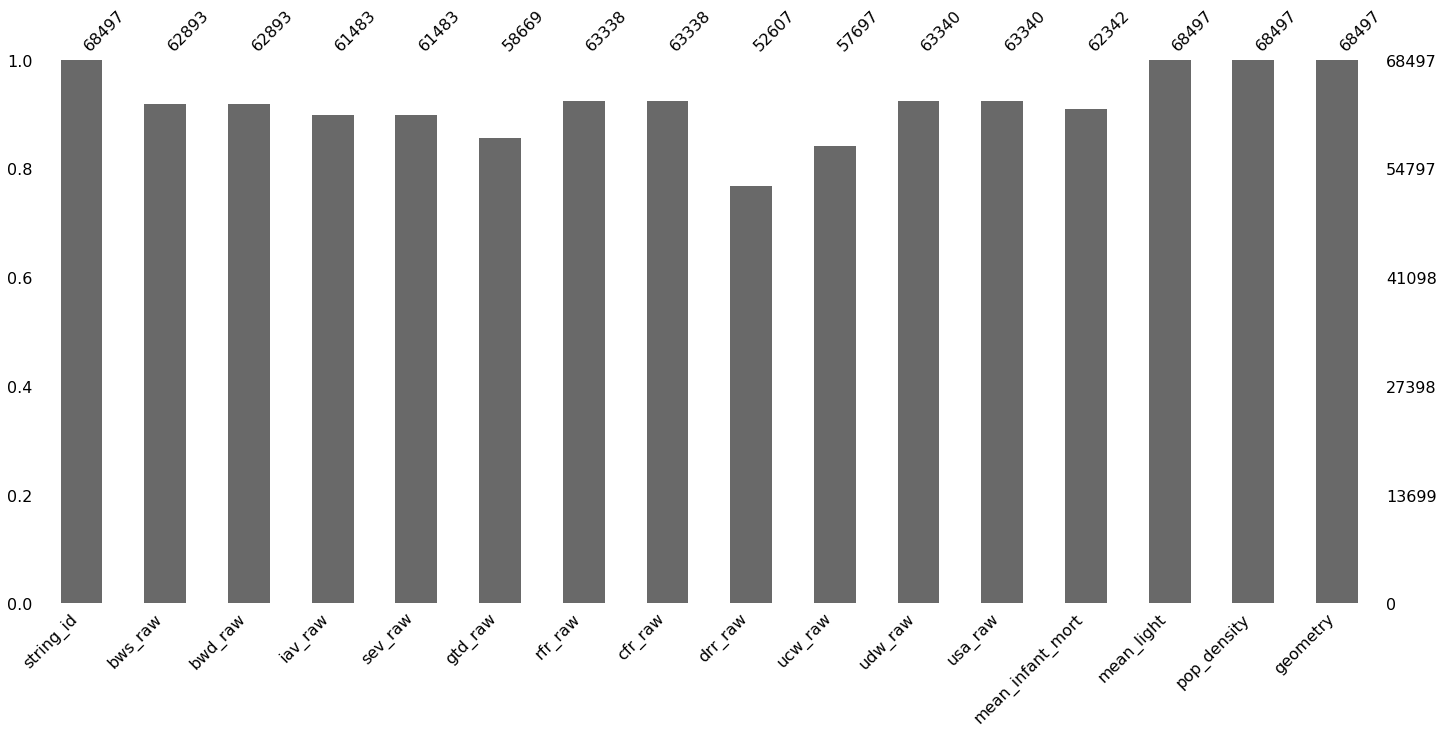

In [10]:
import missingno as msno
msno.bar(data)

In [11]:
data_nona = data.dropna()
data_nona.shape

(42823, 16)

In [12]:
pd.options.display.float_format = '{:.2f}'.format

In [15]:
data_point = data_nona.copy()
data_point.geometry = data_point['geometry'].centroid
data_point['x'] = data_point.geometry.x
data_point['y'] = data_point.geometry.y
data_point.head(5)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,x,y
89,111081-ERI.2_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,33.80,0.00,0.00,POINT (3668636.210972508 2200941.282854759),3668636.21,2200941.28
90,111081-ERI.6_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,44.71,0.08,0.00,POINT (3656272.052900172 2193473.713510732),3656272.05,2193473.71
92,111081-SDN.11_1-1775,0.13,0.04,0.51,1.27,0.16,0.10,0.00,2.22,-1.00,0.22,0.71,39.02,0.19,208.39,POINT (3622482.640097156 2278821.206874764),3622482.64,2278821.21
93,111081-SDN.11_1-1930,0.13,0.04,0.51,1.27,0.06,0.10,0.00,2.22,-1.00,0.22,0.71,39.02,0.25,189.69,POINT (3638748.637192579 2300938.110996285),3638748.64,2300938.11
94,111081-SDN.11_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,39.04,0.10,75.55,POINT (3632484.282508446 2231674.510500768),3632484.28,2231674.51


# Create Pipeline

1. Imputation option for missing data: https://scikit-learn.org/stable/modules/impute.html
1. Standard scaler
1. kmeans
1. optimize K using elbow method: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
1. generate final clusters
1. join clusters back to original data (unscaled)
1. summarise means for each group
1. describe group typologies

## Scaling the values

In [16]:
data_scaled = data_point.copy()
data_scaled = data_scaled.drop(['string_id', 'geometry'], axis=1)
col_names = list(data_scaled.columns)

In [17]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_scaled))
data_scaled.columns = col_names
data_scaled.head()

,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,x,y
0,-0.00,-0.02,0.05,1.81,0.61,5.62,-0.06,-0.09,-2.28,0.61,1.71,0.51,-0.38,-0.18,0.24,-0.03
1,-0.00,-0.02,0.05,1.81,0.61,5.62,-0.06,-0.09,-2.28,0.61,1.71,0.98,-0.36,-0.18,0.23,-0.03
2,-0.00,-0.02,0.05,1.81,0.03,5.62,-0.06,-0.09,-2.28,0.61,1.71,0.74,-0.35,-0.15,0.23,-0.01
3,-0.00,-0.02,0.05,1.81,-0.06,5.62,-0.06,-0.09,-2.28,0.61,1.71,0.74,-0.34,-0.15,0.23,-0.00
4,-0.00,-0.02,0.05,1.81,0.61,5.62,-0.06,-0.09,-2.28,0.61,1.71,0.74,-0.36,-0.17,0.23,-0.02


## Creating the Clusters

In [124]:
eps = .75
min_samples = 15

cores, labels = dbscan(data_scaled, eps = eps, min_samples = min_samples)

print(len(cores))

25915


In [125]:
data_nona['labels'] = labels
data_nona.head()

C:\Users\leoha\Anaconda\envs\musa-620\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,labels
89,111081-ERI.2_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,33.80,0.00,0.00,"(POLYGON ((3668902.175752448 2204796.49083447,...",-1
90,111081-ERI.6_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,44.71,0.08,0.00,(POLYGON ((3667654.988035774 2205403.562746873...,-1
92,111081-SDN.11_1-1775,0.13,0.04,0.51,1.27,0.16,0.10,0.00,2.22,-1.00,0.22,0.71,39.02,0.19,208.39,(POLYGON ((3627835.787313797 2291356.226409634...,-1
93,111081-SDN.11_1-1930,0.13,0.04,0.51,1.27,0.06,0.10,0.00,2.22,-1.00,0.22,0.71,39.02,0.25,189.69,(POLYGON ((3650397.602799883 2309750.193333262...,-1
94,111081-SDN.11_1-3365,0.13,0.04,0.51,1.27,0.84,0.10,0.00,2.22,-1.00,0.22,0.71,39.04,0.10,75.55,(POLYGON ((3632098.253019236 2264728.515082323...,-1


In [126]:
num_clusters = data_nona['labels'].nunique() - 1
print("number of clusters = ", num_clusters)

number of clusters =  118


In [127]:
print(data_nona['labels'].value_counts(dropna =False))

 47     12493
-1      11986
 61      8815
 93      1714
 15       430
        ...  
 29        15
 31        15
 117       13
 54        13
 103       11
Name: labels, Length: 119, dtype: int64


In [128]:
dat_no_noise = data_nona.loc[data_nona['labels'] != -1]

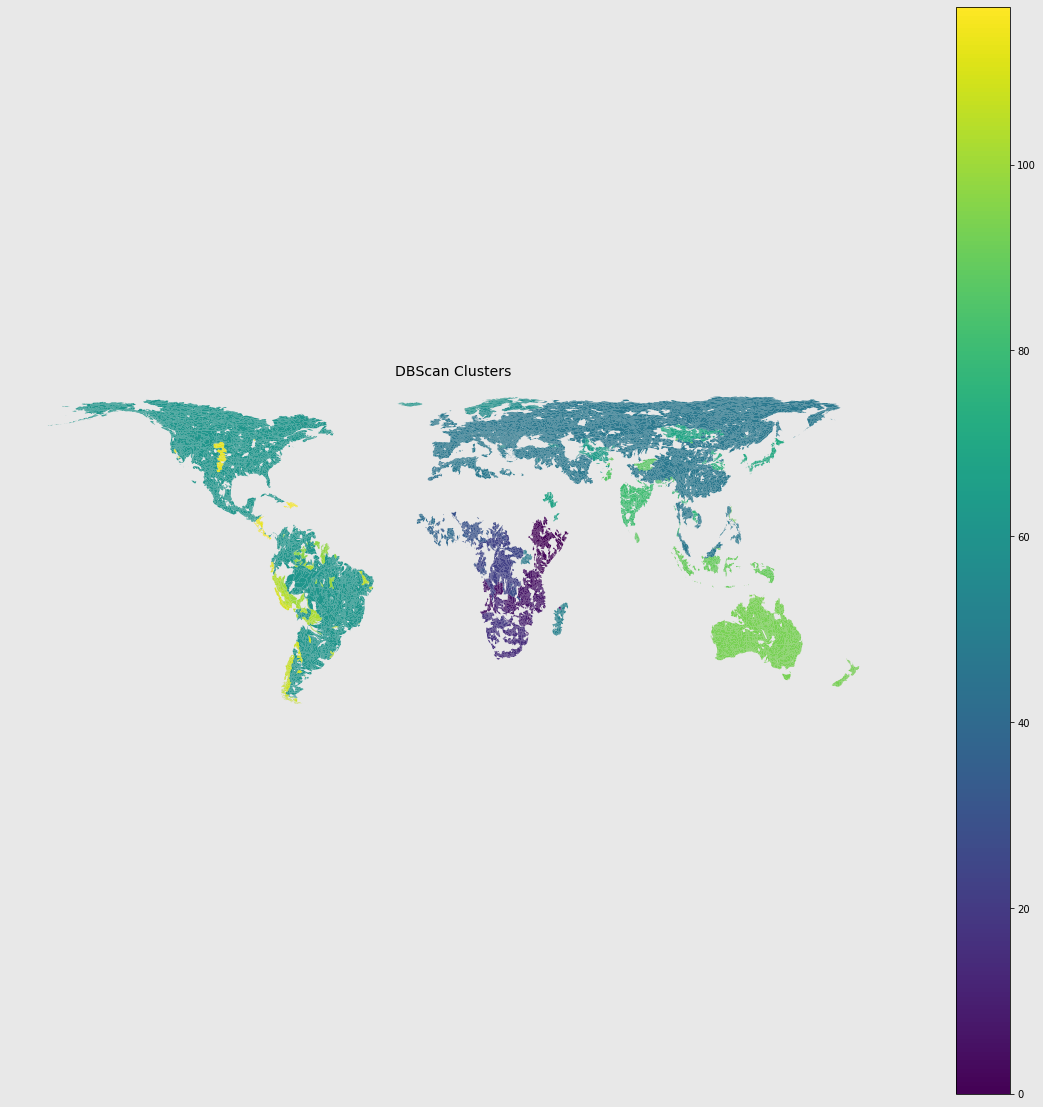

In [129]:
fig, ax = plt.subplots(figsize=(20,20), facecolor='#E8E8E8')
dat_no_noise.plot(ax = ax, column = 'labels', legend=True)#, categorical = True)
ax.set_title("DBScan Clusters", fontsize=14)
ax.set_axis_off()